<a href="https://colab.research.google.com/github/AaravWattal/RRAM-Models/blob/main/MixtureDensityRegressionModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Datasets


In [1]:
# Imports
import numpy as np
import pandas as pd
from time import time

# Scikit-learn stuff
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor

In [2]:
# Get conductange range data from file set_sweep.csv
names = ["addr", "pw", "vwl", "vbsl", "preread", "postread"]
data = pd.read_csv("/content/set_sweep.csv", names=names)
data.head(20)

,addr,pw,vwl,vbsl,preread,postread
0,0,2.000000e-08,0.5,0.5,151240.470700,115068.986900
1,2,2.000000e-08,0.5,1.0,123855.302200,124977.565700
2,4,2.000000e-08,0.5,1.5,127236.989700,106676.196700
3,6,2.000000e-08,0.5,2.0,93031.982770,133852.645200
4,8,2.000000e-08,0.5,2.5,75606.517090,57549.247700
5,10,2.000000e-08,0.5,3.0,97572.302250,92171.401490
6,12,2.000000e-08,0.6,0.5,46314.963040,50373.876070
7,14,2.000000e-08,0.6,1.0,100303.315400,149505.440600
8,16,2.000000e-08,0.6,1.5,212694.720700,75614.854910
9,18,2.000000e-08,0.6,2.0,5747.716015,5608.268993


In [3]:
# data = pd.read_csv("/content/reset_sweep.tsv", sep='\t', names=names)
# data.head(20)

# Data Preprocessing

Let us first convert resistance values (pre-read and post-read) to conductance values, and scale each column so that the maximum value is 1.

In [4]:
# Convert resistance to conductance
data['preread'] = 1 / data['preread']
data['postread'] = 1 / data['postread']

In [5]:
# Creating scaled versions of the columns which have very large or very small scales
data['scaled_pw'] = data['pw'] / np.max(data['pw'])
data['scaled_preread'] = data['preread'] / np.max(data['preread'])
data['scaled_postread'] = data['postread'] / np.max(data['postread'])

In [6]:
# Take a peek at the preprocessed data
data.head(20)

,addr,pw,vwl,vbsl,preread,postread,scaled_pw,scaled_preread,scaled_postread
0,0,2.000000e-08,0.5,0.5,0.000007,0.000009,0.01,0.034318,0.044375
1,2,2.000000e-08,0.5,1.0,0.000008,0.000008,0.01,0.041906,0.040857
2,4,2.000000e-08,0.5,1.5,0.000008,0.000009,0.01,0.040792,0.047866
3,6,2.000000e-08,0.5,2.0,0.000011,0.000007,0.01,0.055790,0.038148
4,8,2.000000e-08,0.5,2.5,0.000013,0.000017,0.01,0.068648,0.088728
5,10,2.000000e-08,0.5,3.0,0.000010,0.000011,0.01,0.053194,0.055399
6,12,2.000000e-08,0.6,0.5,0.000022,0.000020,0.01,0.112064,0.101366
7,14,2.000000e-08,0.6,1.0,0.000010,0.000007,0.01,0.051746,0.034154
8,16,2.000000e-08,0.6,1.5,0.000005,0.000013,0.01,0.024402,0.067529
9,18,2.000000e-08,0.6,2.0,0.000174,0.000178,0.01,0.903011,0.910478


### Train Test Split
Here, we make a 70%-30% split of the data into training and testing datasets

In [7]:
# Train-test 70%-30% split
x = data[["scaled_preread","scaled_pw","vwl","vbsl"]].to_numpy()
y = data["scaled_postread"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [8]:
print(x,"\n",y)

[[0.03431788 0.01       0.5        0.5       ]
 [0.04190577 0.01       0.5        1.        ]
 [0.040792   0.01       0.5        1.5       ]
 ...
 [0.05514082 0.01       0.5        3.        ]
 [0.07995579 0.01       0.6        0.5       ]
 [0.05964901 0.01       0.6        1.        ]] 
 [0.04437516 0.04085697 0.04786639 ... 0.07144795 0.06633775 0.04164925]


###Standard Data Fitting Model

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

In [10]:
#  def generate_data(n_samples):
#     epsilon = np.random.normal(size=(n_samples))
#     x_data = np.random.uniform(-10.5, 10.5, n_samples)
#     y_data = 7*np.sin(0.75*x_data) + 0.5*x_data + epsilon
#     return x_data, y_data
    
# n_samples = 9831
# x_data, y_data = generate_data(n_samples)
# print(type(x_data))

n_samples = 32768

In [11]:
n_input = 4
n_hidden = 20
n_output = 1

network = nn.Sequential(nn.Linear(n_input, n_hidden),
                        nn.ReLU(),
                        nn.Linear(n_hidden, n_output))
network = network.cuda()

In [12]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(network.parameters())

In [13]:
X_train

array([[0.05667327, 0.5       , 2.3       , 1.5       ],
       [0.0324172 , 0.1       , 3.1       , 0.5       ],
       [0.05935437, 0.5       , 1.        , 1.        ],
       ...,
       [0.04290688, 0.2       , 2.8       , 1.5       ],
       [0.05041831, 0.1       , 2.7       , 2.        ],
       [0.14262499, 0.5       , 1.7       , 1.5       ]])

In [14]:
type(x)

numpy.ndarray

In [15]:
x_train_tensor = torch.from_numpy(X_train).cuda()
y_train_tensor = torch.from_numpy(y_train).cuda()
x_train_variable = Variable(x_train_tensor)
y_train_variable = Variable(y_train_tensor, requires_grad=False)

x_test_tensor = torch.from_numpy(X_test).cuda()
y_test_tensor = torch.from_numpy(y_test).cuda()
x_test_variable = Variable(x_test_tensor)
y_test_variable = Variable(y_test_tensor)

In [16]:
def train():
    for epoch in range(3000):
        y_pred = network(x_train_variable.float()) # make a prediction
        loss = loss_fn(y_pred, y_train_variable.float()) # compute the loss
        optimizer.zero_grad() # prepare the optimizer
        loss.backward() # compute the contribution of each parameter to the loss
        optimizer.step() # modify the parameters

        if epoch % 300 == 0:
            print(epoch, loss.data)

train()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([24576])) that is different to the input size (torch.Size([24576, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 tensor(0.1230, device='cuda:0')
300 tensor(0.1033, device='cuda:0')
600 tensor(0.1028, device='cuda:0')
900 tensor(0.1026, device='cuda:0')
1200 tensor(0.1025, device='cuda:0')
1500 tensor(0.1025, device='cuda:0')
1800 tensor(0.1025, device='cuda:0')
2100 tensor(0.1025, device='cuda:0')
2400 tensor(0.1025, device='cuda:0')
2700 tensor(0.1025, device='cuda:0')


In [17]:
network.eval()
output = network(x_test_tensor.float())
print(output)

tensor([[0.4794],
        [0.4794],
        [0.4794],
        ...,
        [0.4794],
        [0.4794],
        [0.4794]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [18]:
print(output.flatten())

tensor([0.4794, 0.4794, 0.4794,  ..., 0.4794, 0.4794, 0.4794], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)


In [19]:
squared_error = (((output.flatten() - y_test_tensor)*(output.flatten() - y_test_tensor))/len(output)).sum().data
print(squared_error)

tensor(0.1024, device='cuda:0', dtype=torch.float64)


In [20]:
print(np.sqrt(squared_error.cpu()))

tensor(0.3200, dtype=torch.float64)


In [21]:
del(squared_error)
del(output)

###MDN

In [22]:
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(4, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu

In [23]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    print(y.shape)
    print(mu.shape)
    print(sigma.shape)
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    print(result.shape)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    #result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

In [24]:
network = MDN(n_hidden=10, n_gaussians=1)
network = network.cuda()
optimizer = torch.optim.Adam(network.parameters())

In [25]:
x_train_tensor = torch.from_numpy(X_train).cuda()
y_train_tensor = torch.from_numpy(y_train).cuda()
x_train_variable = Variable(x_train_tensor)
y_train_variable = Variable(y_train_tensor, requires_grad=False)

x_test_tensor = torch.from_numpy(X_test).cuda()
y_test_tensor = torch.from_numpy(y_test).cuda()
x_test_variable = Variable(x_test_tensor)
y_test_variable = Variable(y_test_tensor)

In [26]:
len(y_train)

24576

In [27]:
batch_size = 64
num_batches = int(len(y_train)/batch_size)
# network.fit(X_train, y_train, epochs=300, )

In [28]:
torch.cuda.empty_cache()

In [29]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

In [30]:
def train_mdn():
    for epoch in range(10000):
      # for batch in range(num_batches):
        pi_variable, sigma_variable, mu_variable = network(x_train_variable.float())
        loss = mdn_loss_fn(pi_variable[:,0], sigma_variable[:,0], mu_variable[:,0], y_train_variable)
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(epoch, loss.data)

train_mdn()

Streaming output truncated to the last 5000 lines.
torch.Size([24576])
torch.Size([24576])
tensor(-1.5181, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
9000 tensor(-1.5181, device='cuda:0', dtype=torch.float64)
torch.Size([24576])
torch.Size([24576])
torch.Size([24576])
torch.Size([24576])
tensor(-1.5181, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([24576])
torch.Size([24576])
torch.Size([24576])
torch.Size([24576])
tensor(-1.5181, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([24576])
torch.Size([24576])
torch.Size([24576])
torch.Size([24576])
tensor(-1.5181, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([24576])
torch.Size([24576])
torch.Size([24576])
torch.Size([24576])
tensor(-1.5181, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([24576])
torch.Size([24576])
torch.Size([24576])
torch.Size([24576])
tensor(-1.5181, device='cuda:0', dtype=torch.float64, g

In [31]:
network.eval()
output = network(x_test_tensor.float())
print(output)

(tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>), tensor([[0.0559],
        [0.0515],
        [0.0631],
        ...,
        [0.0662],
        [0.0757],
        [0.0685]], device='cuda:0', grad_fn=<ExpBackward0>), tensor([[0.8282],
        [0.8629],
        [0.7356],
        ...,
        [0.1138],
        [0.6522],
        [0.7543]], device='cuda:0', grad_fn=<AddmmBackward0>))


In [32]:
pi_variable, sigma_variable, mu_variable = network(x_test_tensor.float())

squared_error = (((mu_variable[:,0] - y_test_tensor)*(mu_variable[:,0] - y_test_tensor))/len(mu_variable)).sum().data
print(squared_error)
print(np.sqrt(0.0043))

tensor(0.0043, device='cuda:0', dtype=torch.float64)
0.06557438524302


In [33]:
print(min(mu_variable))
print(max(mu_variable))
print(min(y_test_tensor))
print(max(y_test_tensor))
print(len(mu_variable))
print(len(y_test_tensor))

tensor([-0.0026], device='cuda:0', grad_fn=<UnbindBackward0>)
tensor([1.0030], device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(0.0076, device='cuda:0', dtype=torch.float64)
tensor(0.9997, device='cuda:0', dtype=torch.float64)
8192
8192


In [34]:
print((mu_variable-y_test_tensor).shape)

torch.Size([8192, 8192])


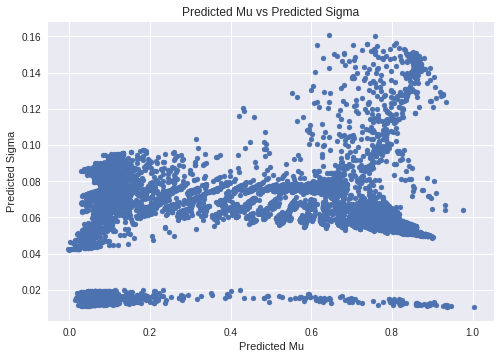

In [35]:
plt.style.use('seaborn')
plt.title("Predicted Mu vs Predicted Sigma")
plt.xlabel("Predicted Mu")
plt.ylabel("Predicted Sigma");
plt.scatter(mu_variable.cpu().detach().numpy()[:,0], sigma_variable.cpu().detach().numpy()[:,0], s=25);

In [41]:
sigma_variable.cpu().detach().numpy()[:,0].shape

(8192,)

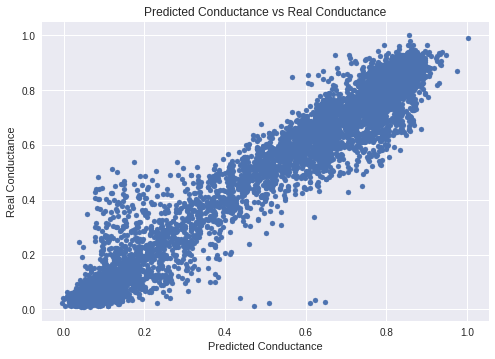

In [37]:
plt.style.use('seaborn')
plt.title("Predicted Conductance vs Real Conductance")
plt.xlabel("Predicted Conductance")
plt.ylabel("Real Conductance");
plt.scatter(mu_variable.cpu().detach().numpy()[:,0], y_test_tensor.cpu().detach().numpy(), s=25);
#plt.scatter(mu_variable.cpu().detach().numpy()[:,0], sigma_variable.cpu().detach().numpy()[:,0], s=25, 'r');

In [ ]:
pi_data = pi_variable.data.cpu().numpy()
sigma_data = sigma_variable.cpu().data.numpy()
mu_data = mu_variable.cpu().data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
# ax1.plot(x_test_data, pi_data)
# ax1.set_title('$\Pi$')
# ax2.plot(x_test_data, sigma_data)
# ax2.set_title('$\sigma$')
# ax3.plot(x_test_data, mu_data)
# ax3.set_title('$\mu$')
# plt.xlim([-15,15])
# plt.show()

In [ ]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(x_test_data, mu_k)
    plt.fill_between(x_test_data, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(mdn_x_data, mdn_y_data, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In [ ]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

In [ ]:
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(mdn_x_data, mdn_y_data, alpha=0.2)
plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
plt.show()

### Training/Testing Old Model

In [ ]:
# Training the MLP regressor
print("Training MLPRegressor...")
tic = time()
est = make_pipeline(
    QuantileTransformer(),
    MLPRegressor(
        hidden_layer_sizes=(45, 23),
        learning_rate_init=0.03,
        early_stopping=True,
        random_state=0,
    ),
)
est.fit(X_train, y_train)
print(f"Done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(X_test, y_test):.5f}")

In [ ]:
# Root Mean Squared Error (RMSE) on training dataset
predictions = est.predict(X_train)
mean_squared_error(y_train, predictions, squared=False)

In [ ]:
# Mean Squared Error (MSE) on training dataset
mean_squared_error(y_train, predictions, squared=True)

In [ ]:
# Root Mean Squared Error (RMSE) on testing dataset
predictions = est.predict(X_test)
predictions_orig = est.predict(X_test)
mean_squared_error(y_test, predictions, squared=False)

In [ ]:
y_test_orig = y_test

In [ ]:
# Mean Squared Error (MSE) on testing dataset
mean_squared_error(y_test, predictions, squared=True)

### Testing on subset of testing data where there was a significant change in conductance (>= 50%)

In [ ]:
# Filter the testing data to a subset
# Condition: |preread - postread| >= 50%
condition = (np.abs(X_test[:,0] - y_test) >= 0.5)
cond_X_test, cond_y_test = X_test[condition], y_test[condition]
cond_X_test, cond_y_test

In [ ]:
# Root Mean Squared Error (RMSE) on training dataset
predictions = est.predict(X_train)
mean_squared_error(y_train, predictions, squared=False)

In [ ]:
# Mean Squared Error (MSE) on training dataset
mean_squared_error(y_train, predictions, squared=True)

In [ ]:
# Root Mean Squared Error (RMSE) on testing dataset
predictions = est.predict(cond_X_test)
mean_squared_error(cond_y_test, predictions, squared=False)

In [ ]:
# Mean Squared Error (MSE) on testing dataset
mean_squared_error(cond_y_test, predictions, squared=True)

### Testing on subset of testing data where there was a miniscule change in conductance (<= 5%)

In [ ]:
# Filter the testing data to a subset
# NOTE: the first column of X_test is preread conductance
# Condition: |preread - postread| <= 5%
condition = (np.abs(X_test[:,0] - y_test) <= 0.05)
cond_X_test, cond_y_test = X_test[condition], y_test[condition]
cond_X_test, cond_y_test

In [ ]:
# Root Mean Squared Error (RMSE) on training dataset
predictions = est.predict(X_train)
mean_squared_error(y_train, predictions, squared=False)

In [ ]:
# Mean Squared Error (MSE) on training dataset
mean_squared_error(y_train, predictions, squared=True)

In [ ]:
# Root Mean Squared Error (RMSE) on testing dataset
predictions = est.predict(cond_X_test)
mean_squared_error(cond_y_test, predictions, squared=False)

In [ ]:
# Mean Squared Error (MSE) on testing dataset
mean_squared_error(cond_y_test, predictions, squared=True)

In [ ]:
#NOTE
#set_sweep mse was 0.0604 for overall test data, 0.0505 for >=50% data, 0.0466 for <=5% data
#reset_sweep mse was 0.0417 for overall test data, 0.4025 for >=50% data, 0.0262 for <=5% data